In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import csv

### Read the XLSX file

In [24]:
# Function to read an Excel file starting from the second row (skips row 1) into a DataFrame

def read_excel_file(file_name, sheet_name):   
    # - skiprows=1 skips the first row (often contains titles or notes, not headers)
    # - engine='openpyxl' ensures compatibility with .xlsx files  
    try:                                    
        df = pd.read_excel(file_name, sheet_name=sheet_name, skiprows=1, engine='openpyxl')
        return df
    except Exception as e:
        print(f"File not found or sheet name '{sheet_name}' invalid from the file '{file_name}': {e}")
        return None

# Read the '1a' sheet which contains house price data, skipping the first row
df_1a = read_excel_file("house-price-to-residence-based-earnings.xlsx", "1a")

# Read the '1b' sheet which contains gross earnings data, also skipping the first row
df_1b = read_excel_file("house-price-to-residence-based-earnings.xlsx", "1b")

print(df_1a)
print(df_1b)


         Code                      Name  Year ending Sep 2002  \
0   K04000001         England and Wales                104000   
1   E92000001                   England                106000   
2   E12000001                North East                 59500   
3   E12000002                North West                 67500   
4   E12000003  Yorkshire and The Humber                 66995   
5   E12000004             East Midlands                 79995   
6   E12000005             West Midlands                 85000   
7   E12000006                      East                118500   
8   E12000007                    London                174000   
9   E12000008                South East                140000   
10  E12000009                South West                115000   
11  W92000004                     Wales                 67500   

    Year ending Sep 2003  Year ending Sep 2004  Year ending Sep 2005  \
0                 125000                145500                156000   
1         

### Data Cleaning & Transformations

In [25]:
# CHECK FOR MISSING VALUES - no missing values present 
df_1a.isnull().sum()
df_1b.isnull().sum()


# CHECK FOR DUPLICATES - no duplicates
df_1a[df_1a.duplicated()]
df_1b[df_1b.duplicated()]


,Code,Name,2002,2003,2004,2005,2006,2007,2008,2009,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024


In [26]:
# RENAME df_1a columns for consistency & STRIP off white spaces for the columns
df_1a.columns=df_1a.columns.str.replace('Year ending Sep ','', regex=False)


In [27]:
# UNPIVOT df_1a data: turn year columns into rows using PANDAS.MELT
df_1a_melted = df_1a.melt(
    id_vars = ['Code','Name'],
    var_name = 'Year',
    value_name = 'HousePrice'
)
df_1a_melted

# UNPIVOT df_1b data: turn year columns into rows using PANDAS.MELT
df_1b_melted = df_1b.melt(
    id_vars = ['Code','Name'],
    var_name = 'Year',
    value_name = 'GrossIncome'
)

In [28]:
# CHECK FOR INCONSISTENT FORMATTING
df_1a_melted.dtypes
df_1b_melted.dtypes


# FIXING DATA TYPES to match df_1a_melted
df_1b_melted['GrossIncome'] = df_1b_melted['GrossIncome'].astype(float)
df_1b_melted.dtypes



Code            object
Name            object
Year            object
GrossIncome    float64
dtype: object

In [29]:
# MERGE THE 2 UNPIVOTTED TABLES TOGETHER
df = df_1a_melted.merge(
    df_1b_melted,
    how='inner',
    on=['Code','Name','Year'])
df

,Code,Name,Year,HousePrice,GrossIncome
0,K04000001,England and Wales,2002,104000.0,20596.0
1,E92000001,England,2002,106000.0,20739.0
2,E12000001,North East,2002,59500.0,18075.0
3,E12000002,North West,2002,67500.0,19281.0
4,E12000003,Yorkshire and The Humber,2002,66995.0,18899.0
...,...,...,...,...,...
248,E12000005,West Midlands,2024,240000.0,35000.0
249,E12000007,London,2024,525000.0,44780.0
250,E12000008,South East,2024,375000.0,40339.0
251,E12000009,South West,2024,302000.0,36112.0


### 1. Descriptive Statistics

In [30]:
# SORT BY DESCENDING House Price per Year
df.groupby('Year').agg({'HousePrice': 'sum'}).sort_values(by='HousePrice',ascending=False)

,HousePrice
Year,
2023,3084495.0
2024,3021495.0
2022,2970995.0
2021,2925482.0
2020,2630900.0
2019,2542450.0
2018,2499945.0
2017,2414995.0
2016,2297550.0


In [31]:
# SORT BY DESCENDING House Price per Region
df.groupby('Name').agg({'HousePrice': 'sum'}).sort_values(by='HousePrice',ascending=False)

# WINDOW FUNCTIONS IN PYTHON - https://www.stratascratch.com/blog/python-window-functions/
# df.groupby('Name').agg({'HousePrice': 'sum','GrossIncome': 'sum'})

# VALIDATE:
# print(sum(df['HousePrice'][df['Year'] == '2002']))

,HousePrice
Name,
London,8150487.0
South East,5999950.0
South West,4905962.0
England,4693732.5
England and Wales,4609545.0
West Midlands,3797400.0
East Midlands,3716916.0
Wales,3300000.0
North West,3295450.0


In [32]:
# MEAN(), STD(), MODE()
avg_house_price = df['HousePrice'].mean()
avg_earnings= df['GrossIncome'].mean()

std_house_price = df['HousePrice'].std()
std_earnings= df['GrossIncome'].std()

mode_house_price = df['HousePrice'].mode().iloc[0]
mode_earnings= df['GrossIncome'].mode().iloc[0]

print("\033[1mAverage\033[0m")
print(f"Average \033[91mhouse price\033[0m across all regions in the UK is \033[91m£{avg_house_price:,.0f}\033[0m.")
print(f"Average \033[91mearnings\033[0m across all regions in the UK is \033[91m£{avg_earnings:,.0f}\033[0m.")
print("\n")
print("\033[1mStandard Deviation\033[0m - amount of variation of the values about its mean")
print(f"Standard Deviation for \033[91mhouse price\033[0m across all regions in the UK is \033[91m£{std_house_price:,.0f}\033[0m.")
print(f"Standard Deviation for \033[91mearnings\033[0m across all regions in the UK is \033[91m£{std_earnings:,.0f}\033[0m.")
print("\n")
print("\033[1mMode\033[0m - most frequent value repeated in the dataset")
print(f"Mode for \033[91mhouse price\033[0m across all regions in the UK is \033[91m£{mode_house_price:,.0f}\033[0m.")
print(f"Mode for \033[91mearnings\033[0m across all regions in the UK is \033[91m£{mode_earnings:,.0f}\033[0m.")


# STD(

Average
Average house price across all regions in the UK is £192,238.
Average earnings across all regions in the UK is £26,984.


Standard Deviation - amount of variation of the values about its mean
Standard Deviation for house price across all regions in the UK is £85,504.
Standard Deviation for earnings across all regions in the UK is £4,858.


Mode - most frequent value repeated in the dataset
Mode for house price across all regions in the UK is £125,000.
Mode for earnings across all regions in the UK is £18,075.


### 2. Distribution Analysis

In [175]:
# Sort the data by region and year to ensure correct calculation
df = df.sort_values(by=['Name','Year'])

# Calculate the percentage change in house prices per region over time
df['HousePrice_Pct_Change'] = round(df.groupby('Name')['HousePrice'].pct_change()*100,2)

df

,Code,Name,Year,HousePrice,GrossIncome,HousePrice_Pct_Change
5,E12000004,East Midlands,2002,79995.0,19513.0,NaN
16,E12000004,East Midlands,2003,99950.0,20245.0,24.95
27,E12000004,East Midlands,2004,123000.0,20935.0,23.06
38,E12000004,East Midlands,2005,130500.0,21950.0,6.10
49,E12000004,East Midlands,2006,135000.0,22187.0,3.45
...,...,...,...,...,...,...
202,E12000003,Yorkshire and The Humber,2020,170000.0,28810.0,3.06
213,E12000003,Yorkshire and The Humber,2021,190000.0,28974.0,11.76
224,E12000003,Yorkshire and The Humber,2022,190000.0,30531.0,0.00
235,E12000003,Yorkshire and The Humber,2023,203000.0,32075.0,6.84


Overall, there is a general upward trend in House Prices from 2002 to 2024.
Particularly, London stands out as having consistently higher house prices.
Regions like North East or Wales might show slower growth, indicating regional disparities in housing markets.


Post-2008 Financial Crisis Impact
There is a dip around 2008-2010 visibile across all regions
showing the effect of the financial crisis on house prices. 
Some regions recovered quicker than others.


Post-2019 Acceleration Post Covid
Quick increase from 2020 onwards, due to increased demand during the pandemic.
Changing remote work patterns, as there seems to be more interest in regions outside of London


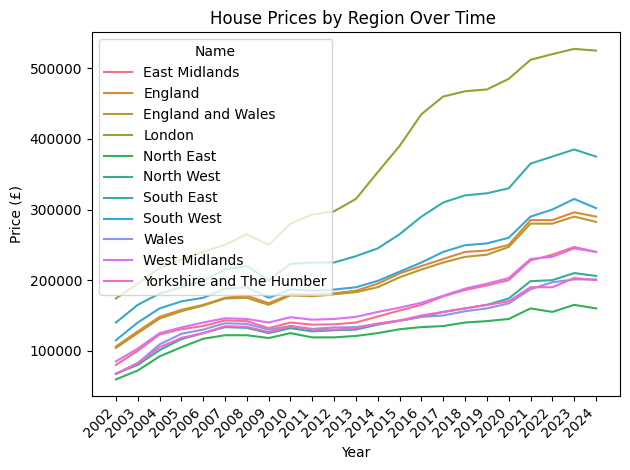

In [283]:
# LINEPLOT TO SHOW HOUSE PRICES TREND BY REGION OVER TIME
sns.lineplot(x='Year',y='HousePrice',hue='Name',data=df)
plt.title("House Prices by Region Over Time ")
plt.xlabel("Year")
plt.ylabel("Price (£)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# INSIGHTS
print("Overall, there is a general upward trend in House Prices from 2002 to 2024." )
print("Particularly, London stands out as having consistently higher house prices." )
print("Regions like North East or Wales might show slower growth, indicating regional disparities in housing markets.")
print("\n")
print("\033[1mPost-2008 Financial Crisis Impact\033[0m")
print("There is a dip around 2008-2010 visibile across all regions")
print("showing the effect of the financial crisis on house prices. " )
print("Some regions recovered quicker than others.")
print("\n")
print("\033[1mPost-2019 Acceleration Post Covid\033[0m")
print("Quick increase from 2020 onwards, due to increased demand during the pandemic.")
print("Changing remote work patterns, as there seems to be more interest in regions outside of London")

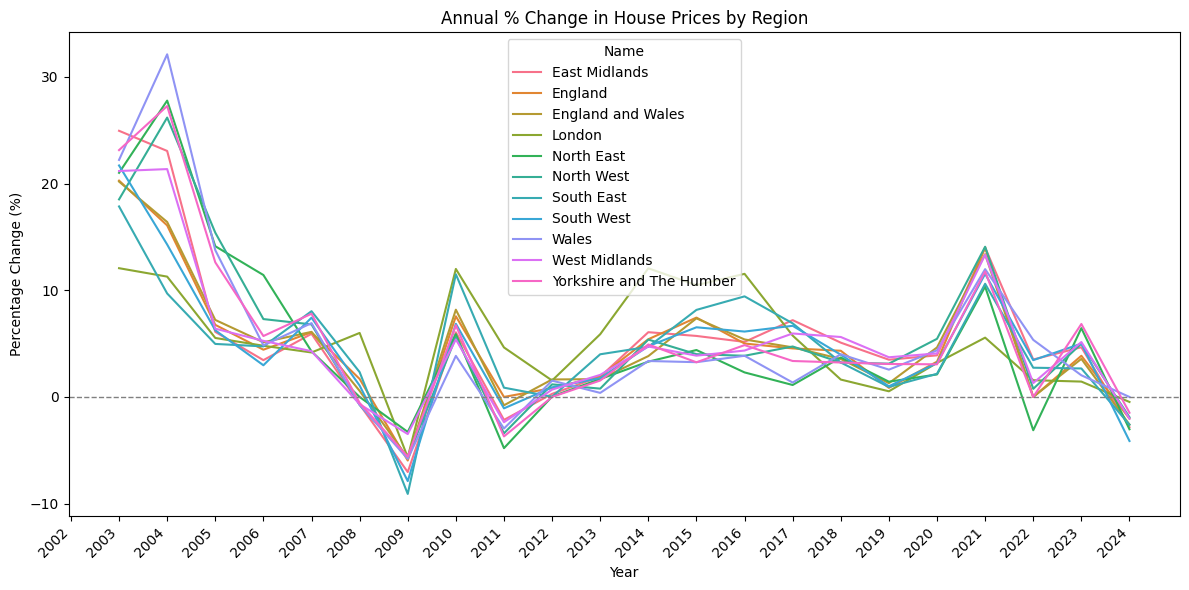

East Midlands’ spike (2003) suggests a period of rapid growth.
Increased demand due to affordability compared to pricier regions.
Regions like North East or Wales might show slower growth, indicating regional disparities in housing markets.




In [428]:
# PERCENTAGE CHANGE OVER TIME
plt.figure(figsize=(12,6))
sns.lineplot(x='Year', y='HousePrice_Pct_Change', hue='Name', data=df)
plt.title("Annual % Change in House Prices by Region")
plt.xlabel("Year")
plt.ylabel("Percentage Change (%)")
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

# HIGHEST PERCENTAGE CHANGE 
max_pct_change = df['HousePrice_Pct_Change']
highest_change_rows = df[df['HousePrice_Pct_Change'] == max_pct_change]
# print(highest_change_rows[['Name', 'Year', 'HousePrice', 'HousePrice_Pct_Change']])
# print(df[df['Name']=='London'])

# INSIGHTS
print("East Midlands’ spike (2003) suggests a period of rapid growth." )
print("Increased demand due to affordability compared to pricier regions." )
print("Regions like North East or Wales might show slower growth, indicating regional disparities in housing markets.")
print("\n")

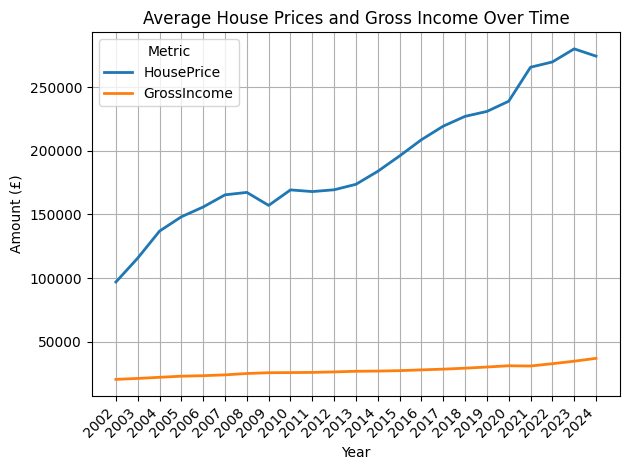

In [429]:
# LINEPLOT TO SHOW HOUSE PRICE AND GROSS INCOME TREND OVER TIME
# STEP 1: Group by Year and compute averages
avg_by_year = df.groupby('Year')[['HousePrice', 'GrossIncome']].mean().reset_index()

# STEP 2: Melt to long format
df_melted = avg_by_year.melt(
    id_vars='Year',
    value_vars=['HousePrice', 'GrossIncome'],
    var_name='Metric',
    value_name='Amount'
)

sns.lineplot(data=df_melted, x='Year', y='Amount', hue='Metric', linewidth=2)

plt.title("Average House Prices and Gross Income Over Time")
plt.xlabel("Year")
plt.ylabel("Amount (£)")
plt.grid(True)
plt.xticks(rotation=45, ha='right')   
plt.tight_layout()

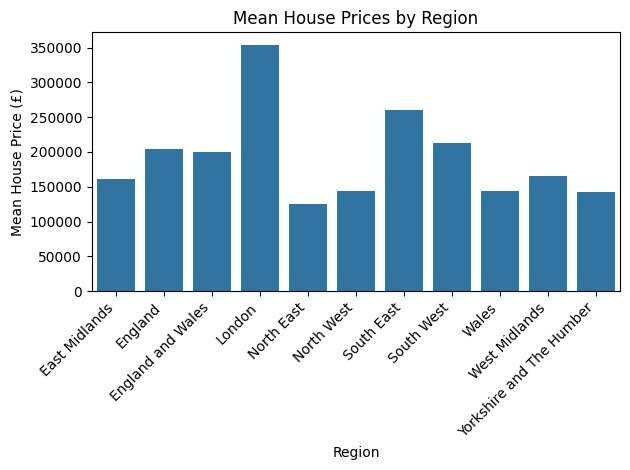

In [430]:
# BARPLOT TO 
# SHOW THE MEAN HOUSE PRICE BY REGION
sns.barplot(x='Name',y='HousePrice',data=df,errorbar=None)
plt.title("Mean House Prices by Region")
plt.xlabel("Region")
plt.ylabel("Mean House Price (£)")
# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')     
plt.tight_layout()


Text(0.5, 1.0, 'Distribution of House Prices by Region')

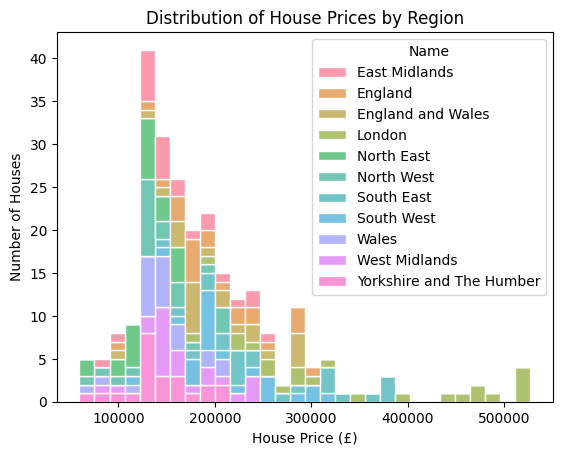

In [431]:
# HISTORGRAM TO SHOW HOW MANY HOUSES FALL WITIHIN EACH PRICE RANGE
sns.histplot(data=df,x='HousePrice',hue='Name',bins=30,multiple='stack',alpha=0.7,edgecolor='white')
# Add labels and title
plt.xlabel("House Price (£)")
plt.ylabel("Number of Houses")
plt.title("Distribution of House Prices by Region")

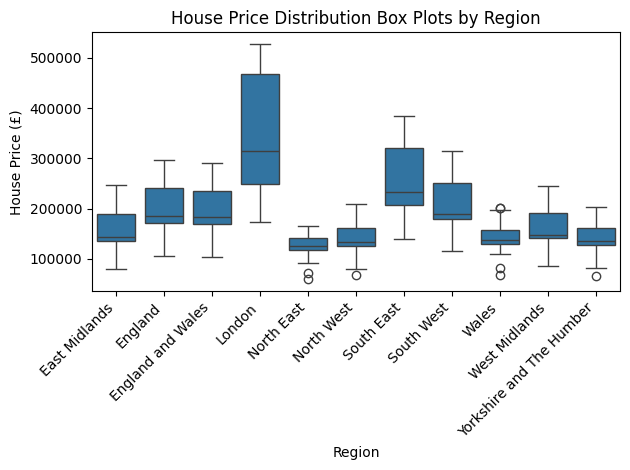

In [432]:
# BOXPLOTS SUMMARISING HOW HOUSE PRICES ARE DISTRIBUTED ACROSS REGIONS
sns.boxplot(x='Name', y='HousePrice', data=df)
plt.title("House Price Distribution Box Plots by Region")
plt.xlabel("Region")
plt.ylabel("House Price (£)")
# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')   
plt.tight_layout()

### 3. Relationship between variables

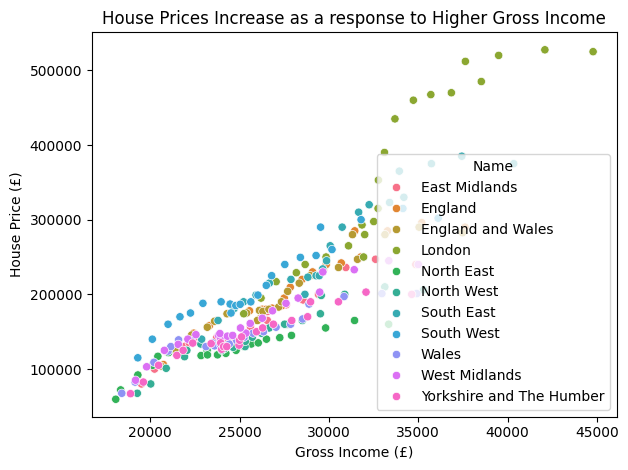

In [433]:
# SCATTER PLOT TO ASSESS IF HOUSE PRICES RISE WITH EARNINGS
sns.scatterplot(data=df, y='HousePrice',x='GrossIncome',hue='Name')
plt.title("House Prices Increase as a response to Higher Gross Income")
plt.xlabel("Gross Income (£)")
plt.ylabel("House Price (£)")
plt.tight_layout()

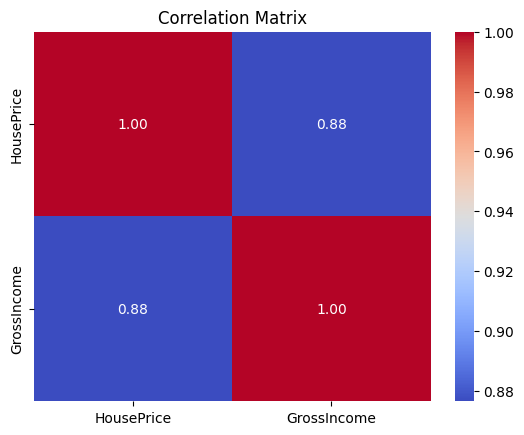

In [434]:
# CORRELATION MATRIX TO SHOW HOW STRONGLY NUMERICAL VARIABLES ARE RELATED
corr_matrix= df[['HousePrice','GrossIncome']].corr()

# Shows strong positive correlation between HousePrice and GrossIncome
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

print()